# **Raspberry Pi Zero 2W Keyword Spotting System**

First, let's install some packages. We will need:
- Tensorflow, for the development of the neural network
- Tensorlow-io, for managing audio arrays and applying signal transformations
- pydub, for splitting audio files

In [1]:
# Installing required packages
!pip install pydub
!pip install tensorflow==2.15.0
!pip install tensorflow-io==0.36.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 28.8 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.37.0
    Uninstalling tensorflow-io-gcs-filesystem-0.37.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.37.0


Let's now download the Speech Commands v2 dataset and extract files inside the proper folder

In [2]:
# Let's download the speech commands dataset
!curl -o speech_commands.tar.gz http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz
!mkdir speech_commands
%cd /content/speech_commands
!tar -xvzf /content/speech_commands.tar.gz
%cd /content/
!mkdir dataset

Streaming output truncated to the last 5000 lines.
./on/db9d52d2_nohash_0.wav
./on/72242187_nohash_4.wav
./on/b0f5b16d_nohash_0.wav
./on/d9aa8c90_nohash_1.wav
./on/525eaa62_nohash_0.wav
./on/42e3f068_nohash_0.wav
./on/94d370bf_nohash_4.wav
./on/bf8d5617_nohash_0.wav
./on/e2b7d6d6_nohash_2.wav
./on/89ed36ab_nohash_0.wav
./on/30276d03_nohash_1.wav
./on/364c0853_nohash_0.wav
./on/7cbf645a_nohash_0.wav
./on/c98bbbd3_nohash_2.wav
./on/9a7c1f83_nohash_5.wav
./on/3589bc72_nohash_0.wav
./on/3ae5c04f_nohash_0.wav
./on/adc216c5_nohash_2.wav
./on/c50f55b8_nohash_15.wav
./on/324210dd_nohash_2.wav
./on/c120e80e_nohash_2.wav
./on/69086eb0_nohash_0.wav
./on/dce05676_nohash_1.wav
./on/435695e3_nohash_1.wav
./on/179a61b7_nohash_1.wav
./on/f5341341_nohash_0.wav
./on/91b03183_nohash_0.wav
./on/96d8bb6f_nohash_2.wav
./on/6a1908f8_nohash_0.wav
./on/6ace4fe1_nohash_1.wav
./on/84d1e469_nohash_1.wav
./on/ba676390_nohash_0.wav
./on/1dc86f91_nohash_4.wav
./on/3a929277_nohash_2.wav
./on/6565a81d_nohash_1.wav
./o

Then, we need to move validation and test files into a proper folder

In [ ]:
import os
import shutil
import random
import librosa
import numpy as np
import soundfile as sf
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
from time import time
from pydub import AudioSegment

In [4]:
def move_files(test_set_file, original_folder, new_folder):
    # Create the new folder if it doesn't exist
    if not os.path.exists(new_folder):
        os.makedirs(new_folder)

    # Read the paths of the test set files
    with open(test_set_file, 'r') as file:
        test_files = file.readlines()

    # Move files from the test set
    for file_path in test_files:
        file_path = file_path.strip()  # Remove leading/trailing whitespace
        class_name, file_name = os.path.split(file_path)  # Extract the class name and file name
        class_name = os.path.basename(class_name)  # Extract the class name from the path
        new_file_name = f"{class_name}_{file_name}"  # Concatenate class name and file name
        original_path = os.path.join(original_folder, file_path)
        new_path = os.path.join(new_folder, new_file_name)

        # Move the file to the new folder
        shutil.move(original_path, new_path)

# Set paths
test_set_file = "/content/speech_commands/testing_list.txt"
val_set_file = "/content/speech_commands/validation_list.txt"
original_folder = "/content/speech_commands"
test_folder = "/content/test_set"
val_folder = "/content/val_set"

# Call the function to move files
move_files(test_set_file, original_folder, test_folder)
move_files(val_set_file, original_folder, val_folder)

We split longer audio files into 1sec ones, these are mainly from noise and background audio files within the dataset

In [5]:
# Path to the folder containing the noise audio files
noise_folder = "/content/speech_commands/_background_noise_/"

# Path to the folder where you want to save the 1-second segments
output_folder = "/content/dataset/"

# Initialize total segment count
total_segments = 0

# Iterate through each noise audio file in the folder
for noise_file in os.listdir(noise_folder):
    if noise_file.endswith(".wav"):  # Assuming all files are WAV format
        noise_path = os.path.join(noise_folder, noise_file)

        # Load the audio file
        audio = AudioSegment.from_wav(noise_path)

        # Get the duration of the audio in milliseconds
        duration_ms = len(audio)

        # Set the step size to 1000 milliseconds (1 second)
        step_size = 1000

        # Take all possible samples from the audio file
        for i in range(0, duration_ms, step_size):
            sample = audio[i:min(i+step_size, duration_ms)]  # Sample with the specified step size

            # Create a filename for the sample (prefix with "nospeaking" + original filename)
            sample_filename = f"{os.path.splitext(noise_file)[0]}_{i // step_size}_nospeaking.wav"

            # Save the sample to the output folder
            sample.export(os.path.join(output_folder, sample_filename), format="wav")

            # Increment total segment count
            total_segments += 1

# Print total segment count
print(f"Total number of segments created: {total_segments}")

Total number of segments created: 402


In [6]:
# Removing the original files to avoid duplicates
!rm -rf /content/speech_commands/_background_noise_/

Now we need to select which categories we want to classify. I decided to classify the following labels `["down", "up", "left", "right", "on", "off", "go", "stop", "yes", "no", "oodwords", "nospeaking"]`, where "oodwords" (out of distribution) stands for all the other categories, so we need to rename them into one single category.  

In [7]:
# Define the list of classes to be grouped as "oodwords"
ood_classes = ["backward", "bed", "bird", "cat", "dog", "zero", "one", "two",
               "three", "four", "five", "six", "seven", "eight", "nine",
               "follow", "forward", "happy", "house", "learn", "marvin",
               "tree", "visual", "wow", "sheila"]

# Path to the source folder containing the class-labeled folders
source_folder = "/content/speech_commands"

# Path to the destination folder
destination_folder = "/content/dataset"

# Iterate through each class-labeled folder in the source folder
for class_folder in os.listdir(source_folder):
    class_path = os.path.join(source_folder, class_folder)

    # Check if the item in the source folder is a directory
    if os.path.isdir(class_path):
        # Iterate through each file in the class folder
        for file_name in os.listdir(class_path):
            # Check if the file is a WAV file
            if file_name.endswith(".wav"):
                file_path = os.path.join(class_path, file_name)

                # Get the class label from the folder name
                class_label = class_folder

                # Check if the class label is among the specified ones
                if class_label in ood_classes:
                    # Avoid putting too much out of distribution words and bias the model
                    #if random.random() < 0.8:
                    #    continue
                    # If so, rename the class label to "oodwords"
                    class_label = f"{class_label}_oodwords"

                # Create a new file name with the updated class label
                new_file_name = f"{file_name.split('.')[0]}_{class_label}.wav"

                # Move the file to the destination folder with the new file name
                shutil.copy(file_path, os.path.join(destination_folder, new_file_name))
print("Oodworded dataset...")

Oodworded dataset...


We need to do the renaming also for validation and test set

In [8]:
def rename_files(folder_path, ood_classes):
    for filename in os.listdir(folder_path):
        if filename.endswith(".wav"):
            # Split the filename into class and filename parts
            name = filename.split(".")[0]
            class_name = name.split("_")[0]
            if class_name in ood_classes:
                # If class is in ood_classes, rename the file
                new_filename = f"{name}_{class_name}_oodwords.wav"
            else:
                new_filename = f"{name}_{class_name}.wav"
            # Rename the file
            os.rename(os.path.join(folder_path, filename), os.path.join(folder_path, new_filename))
    print(f"Renamed filenames.")

rename_files(test_folder, ood_classes)
rename_files(val_folder, ood_classes)

Renamed filenames.
Renamed filenames.


We would like to train on more and more samples, so that our model could be better when handling difficult situations (noisy audios, missing frequencies, faster/slower speech, higher or lower pitches). To do this, we manually add uniform noise (but we can try with gaussian or whatever else) to the audio files. In this way we doubled our training data. We reach 3x with "pitching-up" the audio files.

In [ ]:
def augment_and_save_audio(folder_path):
	files = os.listdir(folder_path)
	for filename in files:
		if filename.endswith(".wav") and not (filename.startswith("hpitched") or filename.startswith("noise")):
			fpath = os.path.join(folder_path, filename)

			audio_tensor = tfio.audio.AudioIOTensor(fpath, tf.int16).to_tensor()
			audio_tensor = tf.squeeze(audio_tensor)
			audio_fp32 = tf.cast(audio_tensor, tf.float32)
			noise = tf.random.uniform(shape=audio_tensor.shape, minval=-8, maxval=8, dtype=tf.int32)
			noise_fp32 = tf.cast(noise, tf.float32)
			noisy_audio = audio_fp32 + noise_fp32
			noisy_audio = noisy_audio.numpy()
			n_path = os.path.join(folder_path, f"noise_{filename}")
			sf.write(n_path, noisy_audio, 16000)

			sound = AudioSegment.from_file(fpath, format="wav")
			new_sample_rate = int(sound.frame_rate * (2.0 ** 0.5))
			hipitch_sound = sound._spawn(sound.raw_data, overrides={'frame_rate':new_sample_rate})
			hipitch_sound = hipitch_sound.set_frame_rate(16000)
			hp_path = os.path.join(folder_path, f"hpitched_{filename}")
			hipitch_sound.export(hp_path, format="wav")
	print("Saved noisy files and high pitched ones...")

folder_path = "/content/dataset"
augment_and_save_audio(folder_path)


Saved noisy files and high pitched ones...


We now define our sets with tensorflow. I like to shuffle the dataset also at the beginning.

In [9]:
train_ds = tf.data.Dataset.list_files("/content/dataset/*")
train_ds = train_ds.shuffle(buffer_size=100000)

val_ds = tf.data.Dataset.list_files("/content/val_set/*")

test_ds = tf.data.Dataset.list_files("/content/test_set/*")

Let's now define some classes that will help us creating a pipeline for the files from .wav to mel spectrogram "images"

In [10]:
class AudioReader():
    def __init__(self, resolution, sampling_rate):
        self.resolution = resolution
        self.sampling_rate = sampling_rate

    def get_audio(self, filename):
        audio_tensor = tfio.audio.AudioIOTensor(filename, self.resolution).to_tensor()
        audio_float32 = tf.cast(tf.squeeze(audio_tensor), tf.float32)
        audio_normalized = audio_float32 / self.resolution.max
        zero_padding = tf.zeros(self.sampling_rate - tf.shape(audio_normalized), dtype=tf.float32)
        audio_padded = tf.concat([audio_normalized, zero_padding], axis=0)
        return audio_padded

    def get_label(self, filename):
        path_parts = tf.strings.split(filename, '/')
        path_end = path_parts[-1]
        file_parts = tf.strings.split(path_end, '_')
        file_end = file_parts[-1]
        label_parts = tf.strings.split(file_end, '.')
        label = label_parts[0]
        return label

    def get_audio_and_label(self, filename):
        audio = self.get_audio(filename)
        label = self.get_label(filename)
        return audio, label

class MelSpectrogram():
    def __init__(
        self,
        sampling_rate,
        frame_length_in_s,
        frame_step_in_s,
        num_mel_bins,
        lower_frequency,
        upper_frequency
    ):
        self.frame_length = int(frame_length_in_s * sampling_rate)
        self.frame_step = int(frame_step_in_s * sampling_rate)
        self.num_spectrogram_bins = self.frame_length // 2 + 1
        self.linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
            num_mel_bins=num_mel_bins,
            num_spectrogram_bins=self.num_spectrogram_bins,
            sample_rate=sampling_rate,
            lower_edge_hertz=lower_frequency,
            upper_edge_hertz=upper_frequency
        )

    def get_mel_spec(self, audio):
        stft = tf.signal.stft(
            audio,
            frame_length=self.frame_length,
            frame_step=self.frame_step,
            fft_length=self.frame_length
        )
        spectrogram = tf.abs(stft)
        mel_spectrogram = tf.matmul(spectrogram, self.linear_to_mel_weight_matrix)
        log_mel_spectrogram = tf.math.log(mel_spectrogram + 1.e-4)

        return log_mel_spectrogram

    def get_mel_spec_and_label(self, audio, label):
        log_mel_spectrogram = self.get_mel_spec(audio)
        return log_mel_spectrogram, label

    def get_masked_mel_spec_and_label(self, mel_spec, label):
        if tf.random.uniform(()) < 0.15:
            freq = tf.random.uniform(minval=0, maxval=56, shape=[], dtype=tf.int32)
            delta_freq = tf.random.uniform(minval=0, maxval=8, shape=[], dtype=tf.int32)
            zero = tf.zeros((61, delta_freq))
            left_slice = mel_spec[:, :freq]
            right_slice = mel_spec[:, freq+delta_freq:]
            mel_spec = tf.concat([left_slice, zero, right_slice], axis=1)
        return mel_spec, label


In [11]:
PREPROCESSING_ARGS = {
    'sampling_rate': 16000,
    'frame_length_in_s': 0.032,
    'frame_step_in_s': 0.016,
    'num_mel_bins': 64,
    'lower_frequency': 20,
    'upper_frequency': 6000,
}

TRAINING_ARGS = {
    'batch_size': 400,
    'initial_learning_rate': 0.01,
    'end_learning_rate': 1e-6,
    'epochs': 20,
}

In [12]:
LABELS = ["down", "up", "left", "right", "on", "off", "go", "stop", "yes", "no", "oodwords", "nospeaking"]

In [13]:
audio_reader = AudioReader(tf.int16, 16000)
mel_spec_processor = MelSpectrogram(**PREPROCESSING_ARGS)

In [14]:
def prepare_for_training(feature, label):
    feature = tf.expand_dims(feature, -1)
    label_id = tf.argmax(label == LABELS)
    return feature, label_id

batch_size = TRAINING_ARGS['batch_size']
epochs = TRAINING_ARGS['epochs']

train_ds = (
    train_ds.map(audio_reader.get_audio_and_label)
    .map(mel_spec_processor.get_mel_spec_and_label)
    .cache()
    .map(mel_spec_processor.get_masked_mel_spec_and_label)
    .map(prepare_for_training)
    .batch(batch_size)
)

val_ds = (
    val_ds.map(audio_reader.get_audio_and_label)
    .map(mel_spec_processor.get_mel_spec_and_label)
    .map(prepare_for_training)
    .batch(batch_size)
    .cache()
)

test_ds = (
    test_ds.map(audio_reader.get_audio_and_label)
    .map(mel_spec_processor.get_mel_spec_and_label)
    .map(prepare_for_training)
    .batch(batch_size)
)


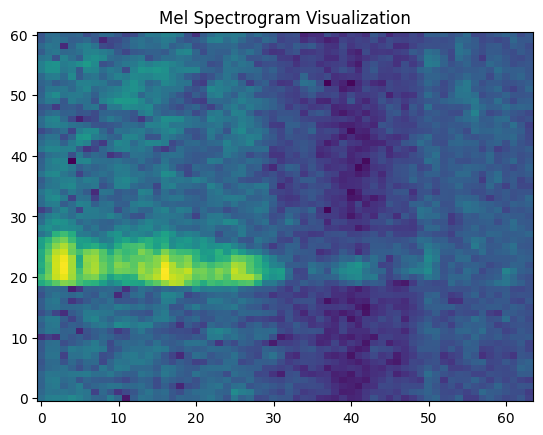

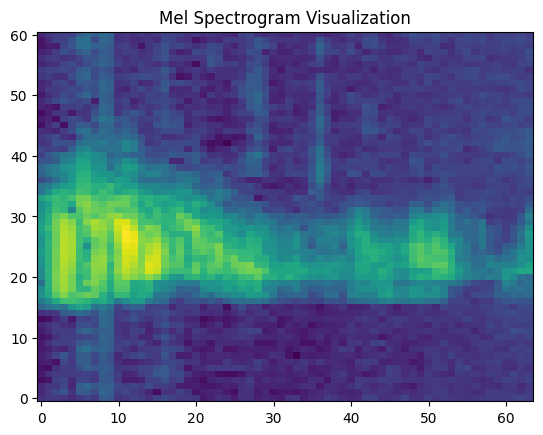

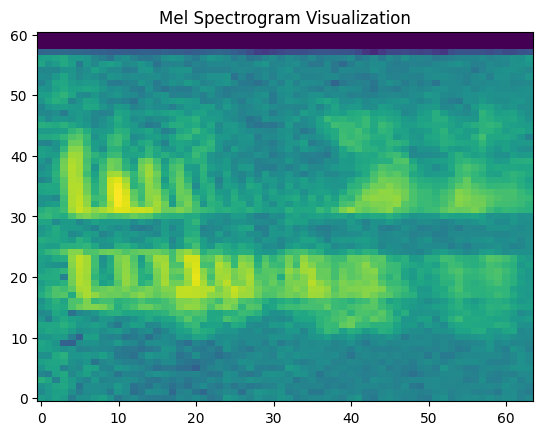

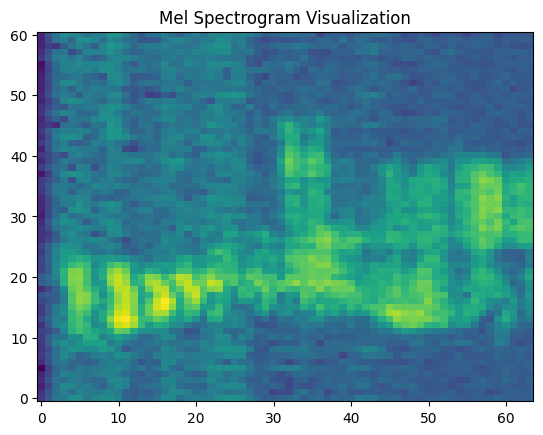

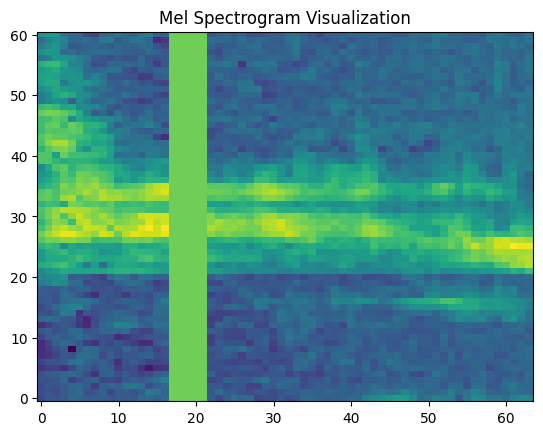

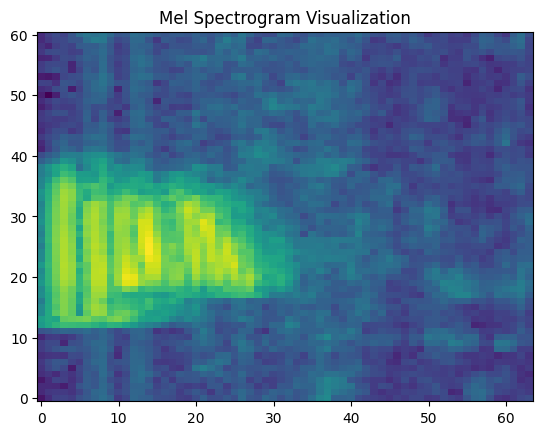

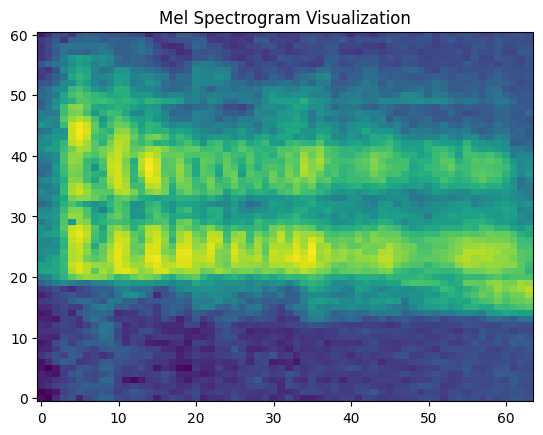

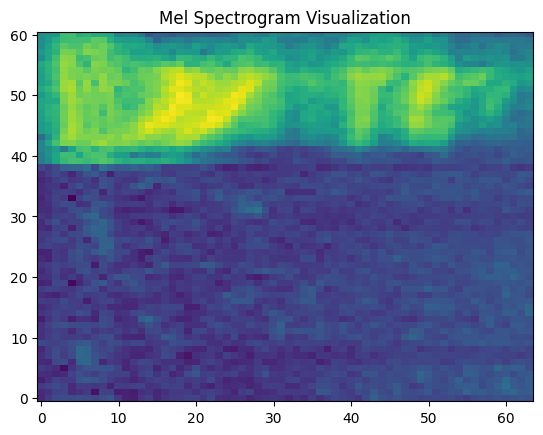

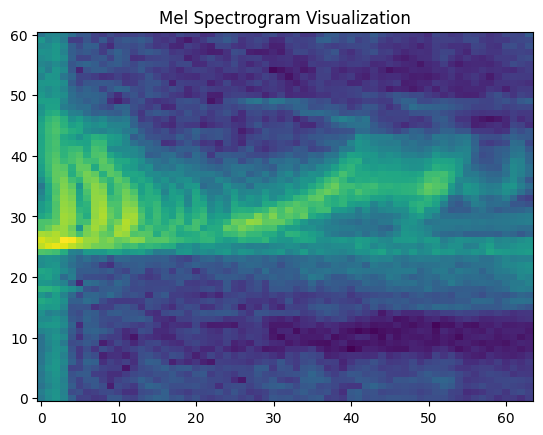

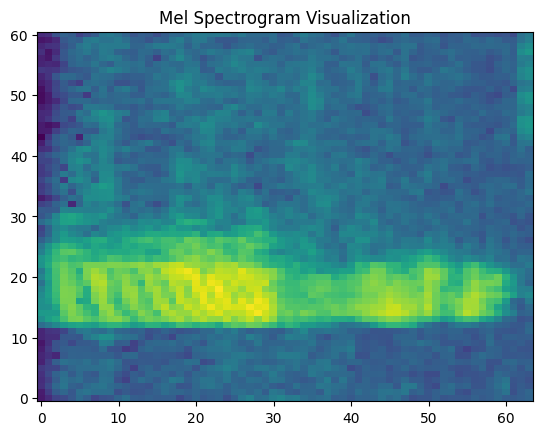

In [16]:
for image, label in train_ds.take(1):
  for el in image[:10]:
    plt.imshow(el, cmap='viridis', origin='lower', aspect='auto')
    plt.title('Mel Spectrogram Visualization')
    plt.show()

Let's now dive into the core of the project: the **network** itself!
Since we feed one spectrogram and expect its classification, we can rely on keras sequential model building style for simplicity.

Essentially, the network has 4 convolution stages (you can see that every MaxPooling2D is terminating our "block") that are useful to extract feature representation from the spectrogram, whereas at the end there is a single Dense layer (FC) to extract probabilities (we use softmax to ensure they sum up to 1) from which we can extract the max value representing the predicted label.

In [ ]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=[64, 64, 1]),
        # 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=[5, 5], strides=[1, 1], use_bias=True, padding="same",),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.SeparableConv2D(filters=32, kernel_size=[3, 3], strides=[1, 1], use_bias=False, padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.DepthwiseConv2D(kernel_size=[3, 3], strides=[1, 1], use_bias=False, padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.MaxPooling2D(pool_size=[2, 2]),
        # 2
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.SeparableConv2D(filters=64, kernel_size=[3, 3], strides=[1, 1], use_bias=True, padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.DepthwiseConv2D( kernel_size=[3, 3], strides=[1, 1], use_bias=False, padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.MaxPooling2D(pool_size=[2, 2]),
        # 3
        tf.keras.layers.SeparableConv2D(filters=128, kernel_size=[3, 3], strides=[1, 1], use_bias=True, padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.DepthwiseConv2D(kernel_size=[3, 3], strides=[1, 1], use_bias=False, padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.MaxPooling2D(pool_size=[2, 2]),
        # 4
        tf.keras.layers.SeparableConv2D(filters=64, kernel_size=[3, 3], strides=[1, 1], use_bias=True, padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Conv2D(filters=32, kernel_size=[3, 3], strides=[1, 1], use_bias=True, padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.DepthwiseConv2D(kernel_size=[3, 3], strides=[1, 1], use_bias=True, padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),

        # Dense
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(units=12),
        tf.keras.layers.Softmax(),
    ]
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        832       
                                                                 
 batch_normalization (Batch  (None, 64, 64, 32)        128       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 64, 64, 32)        0         
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 separable_conv2d (Separabl  (None, 64, 64, 32)        1312      
 eConv2D)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 32)        1

In [ ]:
# define class_weights because we have more samples from the "oodwords" so we need to balance its contribution to the loss
class_weights = {0: 1.0, 1: 1.2, 2: 1.0, 3: 1.0, 4: 2.0, 5: 2.0, 6: 2.0, 7: 2.0, 8: 2.0, 8: 2.0, 9: 2.0, 10: 0.4, 11: 4.0}

loss = tf.losses.SparseCategoricalCrossentropy(from_logits=False)
initial_learning_rate = TRAINING_ARGS["initial_learning_rate"]
end_learning_rate = TRAINING_ARGS["end_learning_rate"]

linear_decay = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    end_learning_rate=end_learning_rate,
    decay_steps=len(train_ds) * epochs,
)
optimizer = tf.optimizers.Adam(learning_rate=linear_decay)
metrics = [tf.metrics.SparseCategoricalAccuracy()]
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, class_weight=class_weights)

Epoch 1/20
640/640 [==============================] - 537s 812ms/step - loss: 0.9001 - sparse_categorical_accuracy: 0.7384 - val_loss: 0.3718 - val_sparse_categorical_accuracy: 0.8726
Epoch 2/20
640/640 [==============================] - 171s 267ms/step - loss: 0.4173 - sparse_categorical_accuracy: 0.8504 - val_loss: 0.3454 - val_sparse_categorical_accuracy: 0.8859
Epoch 3/20
640/640 [==============================] - 171s 268ms/step - loss: 0.3441 - sparse_categorical_accuracy: 0.8747 - val_loss: 0.2027 - val_sparse_categorical_accuracy: 0.9325
Epoch 4/20
640/640 [==============================] - 170s 266ms/step - loss: 0.3047 - sparse_categorical_accuracy: 0.8895 - val_loss: 0.1838 - val_sparse_categorical_accuracy: 0.9385
Epoch 5/20
640/640 [==============================] - 172s 268ms/step - loss: 0.2812 - sparse_categorical_accuracy: 0.8965 - val_loss: 0.1802 - val_sparse_categorical_accuracy: 0.9389
Epoch 6/20
640/640 [==============================] - 172s 268ms/step - loss: 0.

In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)

28/28 [==============================] - 24s 861ms/step - loss: 0.1078 - sparse_categorical_accuracy: 0.9653


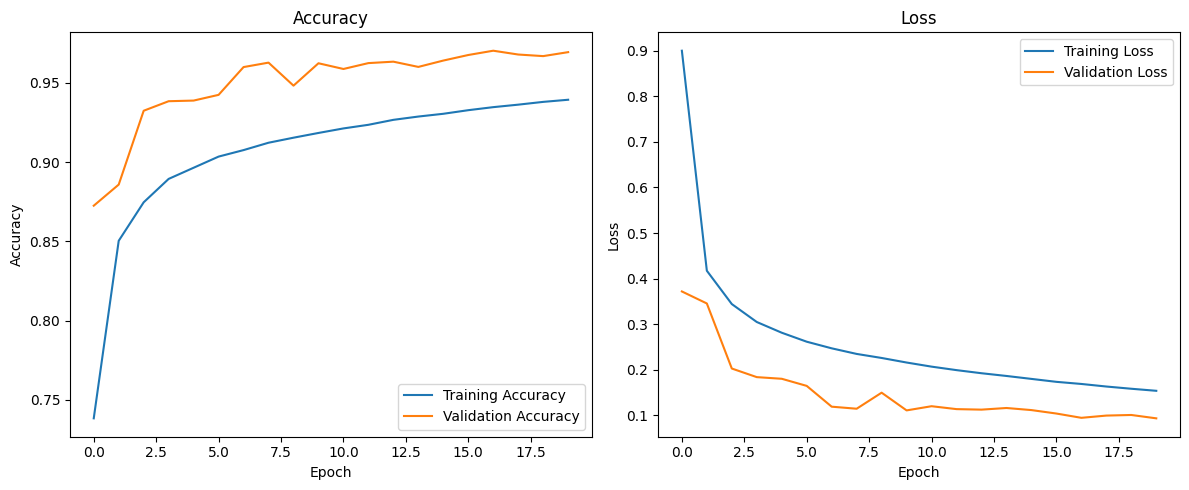

In [ ]:
# Plot training accuracy and loss
plt.figure(figsize=(12, 5))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Let's now save our model and export in tflite format

In [ ]:
model.save("/content/kws")
converter = tf.lite.TFLiteConverter.from_saved_model("/content/kws")
tflite_model = converter.convert()

os.makedirs('./tflite_model', exist_ok=True)

tflite_model_path = os.path.join('./tflite_model', 'kws.tflite')
with open(tflite_model_path, 'wb') as fp:
    fp.write(tflite_model)

## Real Time Keyword Spotting

Let's now build a simple tool that reads audio from a microphone and utilizes the model we created.

In [ ]:
!pip install sounddevice

In [ ]:
import sounddevice as sd
# you can use tflite runtime or tflite from tf itself, which allows to recycle our libraries without the need to switch to librosa or other
# import tflite_runtime as tflite

SAMPLE_RATE = 16000  # Sampling rate (samples per second)
BUFFER_SIZE = SAMPLE_RATE * 1  # Size of the buffer (1 second at 16 kHz)

buffer_audio = np.zeros(BUFFER_SIZE, dtype=np.float32)

interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Define what happens when audio data is recorded ...
def audio_callback(indata, frames, callbacktime, status):
	global audio_buffer
	global mel_spec_processor
	global interpreter

	# Update the buffer and process the audio
	audio_buffer = np.concatenate((audio_buffer[-8000:],indata),axis=0)
	audio_tensor = tf.convert_to_tensor(audio_buffer, dtype=tf.float32)
	audio_tensor = tf.squeeze(audio_tensor)
	audio_tensor = audio_tensor / tf.int16.max
	log_mel_spec = mel_spec_processor.get_mel_spec(audio_tensor)
	# Since the model was setted on a 64,64 input, we have to add some padding here
	log_mel_spec = tf.pad(log_mel_spec, ((0,3),(0,0)), mode='CONSTANT')
	log_mel_spec = tf.expand_dims(log_mel_spec, -1)
	log_mel_spec = tf.expand_dims(log_mel_spec, 0)
	# Running the model
	interpreter.set_tensor(input_details[0]['index'], log_mel_spec)
	interpreter.invoke()
	output = interpreter.get_tensor(output_details[0]['index'])
	label = LABELS[tf.argmax(output[0])]
	print(f'Predicted: {label} with confidence: {output[0][tf.argmax(output[0])]}')

In [ ]:
# Here we process the audio every 0.5s (it is related to blocksize and samplerate)
with sd.InputStream(device=0, samplerate=SAMPLE_RATE, channels=1, dtype='int16', callback=audio_callback, blocksize=SAMPLE_RATE//2):
	print("Capturing audio...")
	while True:
		key = input()
		if key == 'q' or key == 'Q':
			break